# Diagnosisis on the computation of velocity and acceleration 

- [ ] velocity
- [ ] acceleration


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd


#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt


import drifters.utils as ut
import pynsitu as pin

import dask.dataframe as dd
from dask.delayed import delayed

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    #cluster = PBSCluster()
    #w = cluster.scale(jobs=3) # 2 not enough for lon, lat, year, binning
    cluster = PBSCluster(cores=3, processes=3, walltime='04:00:00')
    w = cluster.scale(jobs=8)
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.75:8787/status,
Dashboard: http://10.148.0.75:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.75:35623,Workers: 0
Dashboard: http://10.148.0.75:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
# load data

col_sel = ["time", "lon", "lat",'ve', 'vn', 'id','typebuoy', 'gap',
           'deploy_date', 'deploy_lat','deploy_lon', 'end_date', 'end_lat', 'end_lon', 
           'drogue_lost_date','typedeath', 'lon360', 'err_lat',
           'err_lon', 'err_ve', 'err_vn']

bandwidth = 0.1
df_argos = ut.load_gdp("argos", suffix=f"_filtered_b{bandwidth}")
df_argos = df_argos.where(df_argos!=-1.e+34).reset_index().rename(columns=dict(index="id"))[col_sel].persist()

df_gps = ut.load_gdp("gps", suffix=f"_filtered_b{bandwidth}")
df_gps = (df_gps.where(df_gps!=-1.e+34).reset_index().rename(columns=dict(index="id")))[col_sel].persist() # ATTENTION : replace missing value -1.e+34 by Nan

In [4]:
# dev
#df_gps = dd.concat([df_gps.get_partition(n) for n in range(3)]).persist()
df = df_gps.get_partition(0).groupby('id').get_group(131969).compute()

## Computation : Version pynsitu
Derivation of velocities and acceleration :
- ve, vn already computed via LOWESS METHOD
- vx, vy centered derivation using projection of lon, lat
- acc_x, acc_y double centered derivation using projection of lon, lat
- ae, an centered derivation of ve, vn

In [10]:
def c_vel_acc(df, **kwargs):
    _geo = pin.geo.GeoAccessor(df)
    df0 = _geo.compute_velocities(time="time", centered=True, v_name={'ve':'vex', 'vn':'vny', 'v':'vxy'})
    df1 = _geo.compute_acceleration(time='time', acc_name={'ae':'ae', 'an':'an', 'a':'aen'}, from_ = ('vevn','ve','vn'), centered_velocity=True, )
    df2 = _geo.compute_acceleration(time='time', acc_name={'ae':'aex', 'an':'any', 'a':'axy'}, from_ = ('lonlat','lon','lat') )
    del _geo
    return df0.merge(df1).merge(df2)

In [11]:
df_va = c_vel_acc(df)
df_va

,time,id,lon,lat,vex,vny,vxy,ve,vn,ae,an,aen,aex,any,axy
0,2014-02-18 20:00:00,131969,0.72649,38.723270,-0.028510,-0.419881,0.420848,-0.0298,-0.3110,1.305555e-06,1.555553e-06,2.030818e-06,1.610036e-06,1.728524e-05,1.736006e-05
1,2014-02-18 21:00:00,131969,0.72519,38.713181,-0.028510,-0.419881,0.420848,-0.0320,-0.3121,1.305555e-06,1.555553e-06,2.030818e-06,1.610036e-06,1.728524e-05,1.736006e-05
2,2014-02-18 22:00:00,131969,0.72413,38.705109,-0.025493,-0.359729,0.360631,-0.0204,-0.2998,3.277778e-06,3.444445e-06,4.754790e-06,6.642208e-08,4.575454e-07,4.623415e-07
3,2014-02-18 23:00:00,131969,0.72308,38.697090,-0.025375,-0.358201,0.359099,-0.0084,-0.2873,3.319445e-06,3.486114e-06,4.813700e-06,-7.868580e-10,9.443854e-11,7.925050e-10
4,2014-02-19 00:00:00,131969,0.72203,38.689072,-0.025378,-0.358258,0.359156,0.0035,-0.2747,3.319444e-06,3.499997e-06,4.823763e-06,-7.870937e-10,-3.258051e-08,3.259002e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953,2014-09-13 05:00:00,131969,1.51884,38.679611,0.000363,0.001477,0.001521,0.0000,0.0016,1.805556e-07,-4.444444e-07,4.797199e-07,4.706304e-07,-9.802473e-08,4.807306e-07
4954,2014-09-13 06:00:00,131969,1.51889,38.679630,0.001209,-0.000017,0.001209,0.0012,-0.0016,3.333333e-07,0.000000e+00,3.333333e-07,-8.003918e-10,-1.633747e-07,1.633766e-07
4955,2014-09-13 07:00:00,131969,1.51894,38.679630,0.001570,0.000161,0.001579,0.0024,0.0016,0.000000e+00,4.583333e-07,4.583333e-07,2.016984e-07,4.247743e-07,4.702291e-07
4956,2014-09-13 08:00:00,131969,1.51902,38.679680,0.001933,0.000857,0.002115,0.0012,0.0017,0.000000e+00,-2.222222e-07,2.222222e-07,-1.425016e-13,-2.613995e-07,2.613995e-07


In [ ]:
df_gps_out = df_gps.groupby("id").apply(c_vel_acc).set_index('time')
df_argos_out = df_argos.groupby("id").apply(c_vel_acc).set_index('time')

In [36]:
df_gps_out

,id,lon,lat,vex,vny,v,ae,an,aen,aex,any,axy
npartitions=176,,,,,,,,,,,,
2001-07-01 02:00:00,int64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
2008-07-07 11:00:00,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-06 01:00:00,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-06 03:00:00,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
df_out = df_gps.groupby("id").apply(c_vel_acc).set_index('time')
#df_out = df_argos.groupby("id").apply(velocities_acceleration).set_index('time')
df_out['ae-ax']= df_out['ae']-df_out['acc_x']
df_out['an-ay']= df_out['an']-df_out['acc_y']
df_out['ve-ux']= df_out['ve']-df_out['ux']
df_out['vn-uy']= df_out['vn']-df_out['uy']

In [6]:
abs(df_out.ve.compute()).mean()

0.20368382

In [7]:
abs(df_out.vn.compute()).mean()

0.16797106

In [8]:
abs(df_out.an.compute()).mean()

9.459977822575658e-06

In [7]:
df_out.tail()

,lon,lat,id,ve,vn,x,y,ux,uy,velocity,...,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,ae-ax,an-ay,ve-ux,vn-uy
time,,,,,,,,,,,,,,,,,,,,,
2020-04-06 03:00:00,-36.457001,33.035999,64500820,0.0721,-0.1042,1.945320e+06,-1.120695e+06,0.117460,-0.064094,0.133809,...,0.0,323.542999,0.00085,0.00102,0.0369,0.0369,NaN,NaN,-0.045360,-0.040106
2020-04-06 03:00:00,-23.244511,44.751202,66893250,-0.0199,-0.1042,2.197322e+06,6.102793e+05,0.021092,-0.081204,0.083899,...,0.0,336.755493,0.00085,0.00120,0.0369,0.0369,NaN,NaN,-0.040992,-0.022996
2020-04-06 03:00:00,128.103195,-41.000198,65707180,-0.0878,0.2636,4.869012e+06,-1.470081e+06,0.219573,0.136979,0.258796,...,0.0,128.103195,0.00085,0.00113,0.0369,0.0369,NaN,NaN,-0.307373,0.126621
2020-04-06 03:00:00,42.227501,71.311203,67204880,0.0206,-0.2235,8.519843e+05,4.197143e+04,0.105703,-0.175020,0.204463,...,0.0,42.227501,0.00085,0.00265,0.0369,0.0369,NaN,NaN,-0.085103,-0.048480
2020-04-06 03:00:00,-161.151428,-24.150450,67206560,0.0386,-0.0092,-1.746361e+06,-1.749561e+06,0.018975,-0.003921,0.019376,...,0.0,198.848572,0.00080,0.00087,0.0056,0.0056,NaN,NaN,0.019625,-0.005279


In [8]:
#df_out_p = df_out.persist()

## Load in parquet

In [9]:
df_load.tail()

,time,lon,lat,id,ve,vn,x,y,ux,uy,...,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,ae-ax,an-ay,ve-ux,vn-uy
758,2020-04-06 03:00:00,-36.457001,33.035999,64500820,0.0721,-0.1042,1.945320e+06,-1.120695e+06,0.117460,-0.064094,...,0.0,323.542999,0.00085,0.00102,0.0369,0.0369,NaN,NaN,-0.045360,-0.040106
759,2020-04-06 03:00:00,-23.244511,44.751202,66893250,-0.0199,-0.1042,2.197322e+06,6.102793e+05,0.021092,-0.081204,...,0.0,336.755493,0.00085,0.00120,0.0369,0.0369,NaN,NaN,-0.040992,-0.022996
760,2020-04-06 03:00:00,128.103195,-41.000198,65707180,-0.0878,0.2636,4.869012e+06,-1.470081e+06,0.219573,0.136979,...,0.0,128.103195,0.00085,0.00113,0.0369,0.0369,NaN,NaN,-0.307373,0.126621
761,2020-04-06 03:00:00,42.227501,71.311203,67204880,0.0206,-0.2235,8.519843e+05,4.197143e+04,0.105703,-0.175020,...,0.0,42.227501,0.00085,0.00265,0.0369,0.0369,NaN,NaN,-0.085103,-0.048480
762,2020-04-06 03:00:00,-161.151428,-24.150450,67206560,0.0386,-0.0092,-1.746361e+06,-1.749561e+06,0.018975,-0.003921,...,0.0,198.848572,0.00080,0.00087,0.0056,0.0056,NaN,NaN,0.019625,-0.005279


# Add white noise

In [36]:
df_out_noise = df_out

amp_v = 1
amp_a = 1e-4
def add_white_noise(x, amp):
    return x + np.random.uniform(low= -amp, high=amp )
df_out_noise['ux'] = df_out_noise['ux'].map_partitions(add_white_noise, amp = amp_v)
df_out_noise['uy'] = df_out_noise['uy'].map_partitions(add_white_noise, amp = amp_v)
df_out_noise['acc_x'] = df_out_noise['acc_x'].map_partitions(add_white_noise, amp = amp_a)
df_out_noise['acc_y'] = df_out_noise['acc_y'].map_partitions(add_white_noise, amp = amp_a)
df_out_noise['ve'] = df_out_noise['ve'].map_partitions(add_white_noise, amp = amp_v)
df_out_noise['vn'] = df_out_noise['vn'].map_partitions(add_white_noise, amp = amp_v)
df_out_noise['ae'] = df_out_noise['ae'].map_partitions(add_white_noise, amp = amp_a)
df_out_noise['an'] = df_out_noise['an'].map_partitions(add_white_noise, amp = amp_a)

In [37]:
df_out_noise = df_out_noise[['lon', 'lat', 'id', 've', 'vn', 'x', 'y', 'ux', 'uy', 'velocity',
       'acc_x', 'acc_y', 'acc', 'ae', 'an', 'typebuoy', 'gap', 'deploy_date',
       'deploy_lat', 'deploy_lon', 'end_date', 'end_lat', 'end_lon',
       'drogue_lost_date', 'typedeath', 'lon360', 'err_lat', 'err_lon',
       'err_ve', 'err_vn']]


In [8]:
df_out_noise.tail()

,lon,lat,id,ve,vn,x,y,ux,uy,velocity,...,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn
time,,,,,,,,,,,,,,,,,,,,,
2020-04-06 03:00:00,-36.457001,33.035999,64500820,0.105862,-0.007507,1.945320e+06,-1.120695e+06,0.034746,-0.071575,0.133809,...,NaT,NaN,NaN,2019-03-01,0.0,323.542999,0.00085,0.00102,0.0369,0.0369
2020-04-06 03:00:00,-23.244511,44.751202,66893250,0.013862,-0.007507,2.197322e+06,6.102793e+05,-0.061622,-0.088685,0.083899,...,NaT,NaN,NaN,2020-05-07,0.0,336.755493,0.00085,0.00120,0.0369,0.0369
2020-04-06 03:00:00,128.103195,-41.000198,65707180,-0.054038,0.360293,4.869012e+06,-1.470081e+06,0.136859,0.129498,0.258796,...,NaT,NaN,NaN,NaT,0.0,128.103195,0.00085,0.00113,0.0369,0.0369
2020-04-06 03:00:00,42.227501,71.311203,67204880,0.054362,-0.126807,8.519843e+05,4.197143e+04,0.022989,-0.182501,0.204463,...,NaT,NaN,NaN,2019-08-29,0.0,42.227501,0.00085,0.00265,0.0369,0.0369
2020-04-06 03:00:00,-161.151428,-24.150450,67206560,0.072362,0.087493,-1.746361e+06,-1.749561e+06,-0.063739,-0.011402,0.019376,...,NaT,NaN,NaN,2019-08-20,0.0,198.848572,0.00080,0.00087,0.0056,0.0056


# Store in parquet

In [7]:
root_dir = "/home1/datawork/mdemol/GDP"
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")

parquet_argos_noise = os.path.join(root_dir, f"argos_av_noise_{amp_v}_{amp_a}.parquet")
parquet_gps_noise = os.path.join(root_dir, f"gps_av_noise_{amp_v}_{amp_a}.parquet")

NameError: name 'amp_v' is not defined

In [8]:
df_load = (#df_out_noise
           df_out
           .reset_index()
            .repartition(partition_size="100MB")
            .persist()
           )

In [9]:
#df_load.to_parquet(parquet_gps_noise, engine='pyarrow') # alternative: fastparquet
df_load.to_parquet(parquet_gps, engine='pyarrow') # alternative: fastparquet

In [10]:
df_gps_reload = dd.read_parquet(parquet_gps)

In [11]:
df_gps_reload[df_gps_reload.lon==np.nan].compute()

,time,lon,lat,id,ve,vn,x,y,ux,uy,...,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,ae-ax,an-ay,ve-ux,vn-uy


In [12]:
df_gps_reload.columns

Index(['lon', 'lat', 've', 'vn', 'x', 'y', 'ux', 'uy', 'velocity', 'acc_x',
       'acc_y', 'acc', 'ae', 'an', 'typebuoy', 'gap', 'deploy_date',
       'deploy_lat', 'deploy_lon', 'end_date', 'end_lat', 'end_lon',
       'drogue_lost_date', 'typedeath', 'lon360', 'err_lat', 'err_lon',
       'err_ve', 'err_vn', 'ae-ax', 'an-ay', 've-ux', 'vn-uy'],
      dtype='object')

## Visualisation 

In [14]:
df_out['acc_x'].plot(label='acceleration from lon,lat')
df_out['ae'].plot(label='acceleration from ve,vn')
plt.legend()

AttributeError: 'Series' object has no attribute 'plot'

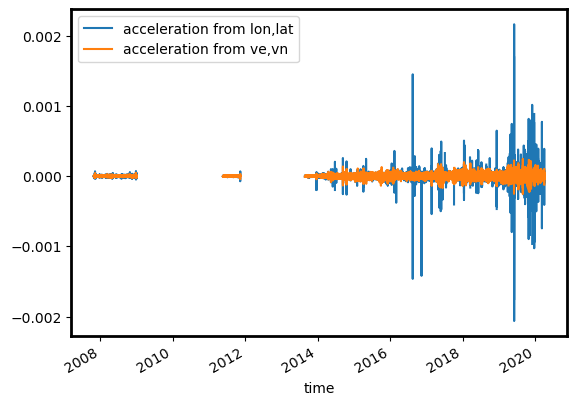

In [13]:
df_out['acc_y'].plot(label='acceleration from lon,lat')
df_out['an'].plot(label='acceleration from ve,vn')
plt.legend()

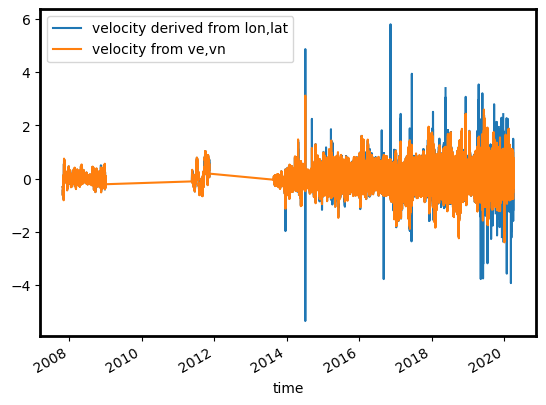

In [14]:
df_out['ux'].plot(label='velocity derived from lon,lat')
df_out['ve'].plot(label='velocity from ve,vn')
plt.legend()

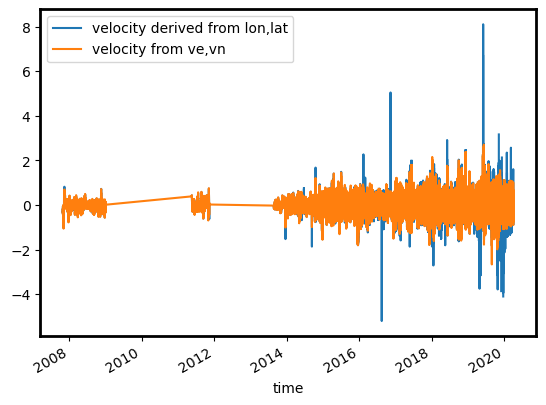

In [15]:
df_out['uy'].plot(label='velocity derived from lon,lat')
df_out['vn'].plot(label='velocity from ve,vn')
plt.legend()

In [37]:
cluster.close()